### Plotting PTMs in Comet and PEAKS results using python for *Prochlococcus* MED4 benchmark study

Starting with:

    Peaks de novo results (.csv) of PTM-optimized sequencing
    Comet results from PTM-optimized database searches

Goal:

    Figures comparing the modifcation type and extent in database and de novo peptides
    
Using:

    - pandas
    - matplotlib

In [1]:
# LIBRARIES
#import pandas library for working with tabular data
import os
os.getcwd()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib import pyplot
import seaborn as sns
from scipy.stats import kde
#import regular expresson (regex)
import re
#check pandas version
pd.__version__

'1.0.5'

In [2]:
# read in csvs made in MED4-PeaksDB and MED4-Comet notebooks
# bringing in Comet > XCorr 3 and de novo peptides > 50% ALC

peaks50 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_combine_PTMopt_DN50_totals.csv")
peaks80 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_combine_PTMopt_DN80_totals.csv")
comet25 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/TPP/RAL95_MED2_trypsin_combine_Comet25_totals.csv")
comet3 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/TPP/RAL95_MED2_trypsin_combine_Comet3_totals.csv")

frames = [peaks50, peaks80, comet25, comet3]
index = ['peaks50', 'peaks80', 'comet2.5', 'comet3']

# concatenate dataframes
tot = pd.concat(frames, sort=False, ignore_index=True)

# there's a useless column in there
tot = tot.loc[:, ~tot.columns.str.contains('^Unnamed')]

# reindex with peaks and comet
names = ['peaks50', 'peaks80', 'comet2.5', 'comet3']
tot.insert(loc=0, column='data source', value=names)
tot.set_index('data source')

# separate out the dataframe into AAs and %PTMs, too
AA = tot[['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']].copy()

# no C since it's the same #ptm = tot[['% C w/ carb.', '% M w/ oxid', '% N w/ deam', '% Q w/ deam', '% K w/ iron', '% K w/ meth', '% R w/ meth']].copy()
ptm = tot[['% M w/ oxid', '% N w/ deam', '% Q w/ deam', '% K w/ iron', '% K w/ meth', '% R w/ meth']].copy()

In [3]:
# read in csvs made in MED4-PeaksDB with NAAF normalized AAs

peaksNAAF50 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_combine_PTMopt_DN50_AA_NAAF.csv")
peaksNAAF80 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_combine_PTMopt_DN80_AA_NAAF.csv")

# there's a useless column in there
peaksNAAF50 = peaksNAAF50.loc[:, ~peaksNAAF50.columns.str.contains('^Unnamed')]
peaksNAAF80 = peaksNAAF80.loc[:, ~peaksNAAF80.columns.str.contains('^Unnamed')]

peaksNAAF50.head()

,stripped peptide,NAAF factor,A,C,D,E,F,G,H,K,...,M-NAAF50,N-NAAF50,P-NAAF50,Q-NAAF50,R-NAAF50,S-NAAF50,T-NAAF50,V-NAAF50,W-NAAF50,Y-NAAF50
0,KELNLDTDLGK,0.055396,0,0,2,1,0,1,0,2,...,0.000000,0.055396,0.0,0.000000,0.0,0.000000,0.055396,0.0,0.000000,0.000000
1,KDLESLDSTNK,0.088380,0,0,2,1,0,0,0,2,...,0.000000,0.088380,0.0,0.000000,0.0,0.176759,0.088380,0.0,0.000000,0.000000
2,FFLLFK,0.304290,0,0,0,0,3,0,0,1,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
3,KLFTDYQELMK,0.099163,0,0,1,1,1,0,0,2,...,0.099163,0.000000,0.0,0.099163,0.0,0.000000,0.099163,0.0,0.000000,0.099163
4,WALEELLNK,1.126712,1,0,0,2,0,0,0,1,...,0.000000,1.126712,0.0,0.000000,0.0,0.000000,0.000000,0.0,1.126712,0.000000


In [4]:
# made a new dataframe that contains the sums of NAAF normalized AAs for Peaks >50%

index = ['sample total']

data = {'A-NAAF': peaksNAAF50['A-NAAF50'].sum(),
        'C-NAAF': peaksNAAF50['C-NAAF50'].sum(),
        'D-NAAF': peaksNAAF50['D-NAAF50'].sum(),
        'E-NAAF': peaksNAAF50['E-NAAF50'].sum(),
        'F-NAAF': peaksNAAF50['F-NAAF50'].sum(),
        'G-NAAF': peaksNAAF50['G-NAAF50'].sum(),
        'H-NAAF': peaksNAAF50['H-NAAF50'].sum(),
        'K-NAAF': peaksNAAF50['K-NAAF50'].sum(),
        'I/L-NAAF': peaksNAAF50['I/L-NAAF50'].sum(),
        'M-NAAF': peaksNAAF50['M-NAAF50'].sum(),
        'N-NAAF': peaksNAAF50['N-NAAF50'].sum(),
        'P-NAAF': peaksNAAF50['P-NAAF50'].sum(),
        'Q-NAAF': peaksNAAF50['Q-NAAF50'].sum(),
        'R-NAAF': peaksNAAF50['R-NAAF50'].sum(),
        'S-NAAF': peaksNAAF50['S-NAAF50'].sum(),
        'T-NAAF': peaksNAAF50['T-NAAF50'].sum(),
        'V-NAAF': peaksNAAF50['V-NAAF50'].sum(),
        'W-NAAF': peaksNAAF50['W-NAAF50'].sum(),
        'Y-NAAF': peaksNAAF50['Y-NAAF50'].sum()
       }

totalpeaksNAAF50 = pd.DataFrame(data, columns=['A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', 'G-NAAF', 'H-NAAF', 'K-NAAF', 'I/L-NAAF', 'M-NAAF', 'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', 'T-NAAF', 'V-NAAF', 'W-NAAF', 'Y-NAAF'], index=index)
totalpeaksNAAF50.head()

,A-NAAF,C-NAAF,D-NAAF,E-NAAF,F-NAAF,G-NAAF,H-NAAF,K-NAAF,I/L-NAAF,M-NAAF,N-NAAF,P-NAAF,Q-NAAF,R-NAAF,S-NAAF,T-NAAF,V-NAAF,W-NAAF,Y-NAAF
sample total,39572.808938,5213.700112,18812.442809,32560.689448,12573.764709,30120.599637,5194.80258,70379.795028,80389.336843,7728.046586,24804.475783,24023.033137,14675.623831,32103.969946,43802.787271,52386.280507,68709.028648,7130.995459,11124.981222


In [ ]:
totalpeaksNAAF = pd.DataFrame(data, columns=['A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', 'G-NAAF', 'H-NAAF', 'K-NAAF', 'I/L-NAAF', 'M-NAAF', 'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', 'T-NAAF', 'V-NAAF', 'W-NAAF', 'Y-NAAF'], index=index)

In [5]:
# made a new dataframe that contains the sums of NAAF normalized AAs for Peaks >80%

index = ['sample total']

data = {'A-NAAF': peaksNAAF80['A-NAAF80'].sum(),
        'C-NAAF': peaksNAAF80['C-NAAF80'].sum(),
        'D-NAAF': peaksNAAF80['D-NAAF80'].sum(),
        'E-NAAF': peaksNAAF80['E-NAAF80'].sum(),
        'F-NAAF': peaksNAAF80['F-NAAF80'].sum(),
        'G-NAAF': peaksNAAF80['G-NAAF80'].sum(),
        'H-NAAF': peaksNAAF80['H-NAAF80'].sum(),
        'K-NAAF': peaksNAAF80['K-NAAF80'].sum(),
        'I/L-NAAF': peaksNAAF80['I/L-NAAF80'].sum(),
        'M-NAAF': peaksNAAF80['M-NAAF80'].sum(),
        'N-NAAF': peaksNAAF80['N-NAAF80'].sum(),
        'P-NAAF': peaksNAAF80['P-NAAF80'].sum(),
        'Q-NAAF': peaksNAAF80['Q-NAAF80'].sum(),
        'R-NAAF': peaksNAAF80['R-NAAF80'].sum(),
        'S-NAAF': peaksNAAF80['S-NAAF80'].sum(),
        'T-NAAF': peaksNAAF80['T-NAAF80'].sum(),
        'V-NAAF': peaksNAAF80['V-NAAF80'].sum(),
        'W-NAAF': peaksNAAF80['W-NAAF80'].sum(),
        'Y-NAAF': peaksNAAF80['Y-NAAF80'].sum()
       }

totalpeaksNAAF80 = pd.DataFrame(data, columns=['A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', 'G-NAAF', 'H-NAAF', 'K-NAAF', 'I/L-NAAF', 'M-NAAF', 'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', 'T-NAAF', 'V-NAAF', 'W-NAAF', 'Y-NAAF'], index=index)
totalpeaksNAAF80.head()

,A-NAAF,C-NAAF,D-NAAF,E-NAAF,F-NAAF,G-NAAF,H-NAAF,K-NAAF,I/L-NAAF,M-NAAF,N-NAAF,P-NAAF,Q-NAAF,R-NAAF,S-NAAF,T-NAAF,V-NAAF,W-NAAF,Y-NAAF
sample total,12164.760623,1452.705723,5516.798444,11947.333781,4401.643851,9278.315957,1011.824625,26105.400315,31455.333104,1894.188826,8483.499981,6347.037088,4680.178057,11605.461473,18203.714679,22920.324366,30526.668468,1240.996147,3413.735929


In [ ]:
totalpeaksNAAF = pd.DataFrame(data, columns=['A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', 'G-NAAF', 'H-NAAF', 'K-NAAF', 'I/L-NAAF', 'M-NAAF', 'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', 'T-NAAF', 'V-NAAF', 'W-NAAF', 'Y-NAAF'], index=index)

In [92]:
frames = [totalpeaksNAAF50, totalpeaksNAAF80]
index = ['totalpeaksNAAF50', 'totalpeaksNAAF80']

# concatenate dataframes
NAAFtot = pd.concat(frames, sort=False, ignore_index=True)

# reindex 
names = ['peaks50', 'peaks80']
NAAFtot.insert(loc=0, column='data source', value=names)
NAAFtot.set_index('data source')

# sum all the AAs in each dataset, making a new column
NAAFtot['AA-Total-NAAF'] = NAAFtot['A-NAAF'] + NAAFtot['C-NAAF'] + NAAFtot['D-NAAF'] + NAAFtot['E-NAAF'] \
+ NAAFtot['F-NAAF'] + NAAFtot['G-NAAF'] + NAAFtot['H-NAAF'] + NAAFtot['K-NAAF'] + NAAFtot['I/L-NAAF'] \
+ NAAFtot['M-NAAF'] + NAAFtot['N-NAAF'] + NAAFtot['P-NAAF'] + NAAFtot['Q-NAAF'] + NAAFtot['R-NAAF'] \
+ NAAFtot['S-NAAF'] + NAAFtot['T-NAAF'] + NAAFtot['V-NAAF'] + NAAFtot['W-NAAF'] + NAAFtot['Y-NAAF'] \

# calculate the relative (NAAF-normalized) AA composition (fractions of AA total for each dataset)

NAAFtot['A_RelNAAF'] = NAAFtot['A-NAAF']/NAAFtot['AA-Total-NAAF']  #A
NAAFtot['C_RelNAAF'] = NAAFtot['C-NAAF']/NAAFtot['AA-Total-NAAF']  #C
NAAFtot['D_RelNAAF'] = NAAFtot['D-NAAF']/NAAFtot['AA-Total-NAAF']  #D
NAAFtot['E_RelNAAF'] = NAAFtot['E-NAAF']/NAAFtot['AA-Total-NAAF']  #E
NAAFtot['F_RelNAAF'] = NAAFtot['F-NAAF']/NAAFtot['AA-Total-NAAF']  #F
NAAFtot['G_RelNAAF'] = NAAFtot['G-NAAF']/NAAFtot['AA-Total-NAAF']  #G
NAAFtot['H_RelNAAF'] = NAAFtot['H-NAAF']/NAAFtot['AA-Total-NAAF']  #H
NAAFtot['K_RelNAAF'] = NAAFtot['K-NAAF']/NAAFtot['AA-Total-NAAF']  #K
NAAFtot['I/L_RelNAAF'] = NAAFtot['I/L-NAAF']/NAAFtot['AA-Total-NAAF']  #I/L
NAAFtot['M_RelNAAF'] = NAAFtot['M-NAAF']/NAAFtot['AA-Total-NAAF']  #M
NAAFtot['N_RelNAAF'] = NAAFtot['N-NAAF']/NAAFtot['AA-Total-NAAF']  #N
NAAFtot['P_RelNAAF'] = NAAFtot['P-NAAF']/NAAFtot['AA-Total-NAAF']  #P
NAAFtot['Q_RelNAAF'] = NAAFtot['Q-NAAF']/NAAFtot['AA-Total-NAAF']  #Q
NAAFtot['R_RelNAAF'] = NAAFtot['R-NAAF']/NAAFtot['AA-Total-NAAF']  #R
NAAFtot['S_RelNAAF'] = NAAFtot['S-NAAF']/NAAFtot['AA-Total-NAAF']  #S
NAAFtot['T_RelNAAF'] = NAAFtot['T-NAAF']/NAAFtot['AA-Total-NAAF']  #T
NAAFtot['V_RelNAAF'] = NAAFtot['V-NAAF']/NAAFtot['AA-Total-NAAF']  #V
NAAFtot['W_RelNAAF'] = NAAFtot['W-NAAF']/NAAFtot['AA-Total-NAAF']  #W
NAAFtot['Y_RelNAAF'] = NAAFtot['Y-NAAF']/NAAFtot['AA-Total-NAAF']  #Y

# make a smaller dataframe with just the relative, NAAF-normalized AA compositions
AA_RelNAAF = NAAFtot[['A_RelNAAF', 'C_RelNAAF', 'D_RelNAAF', 'E_RelNAAF', 'F_RelNAAF', 'G_RelNAAF', 'H_RelNAAF', \
                      'K_RelNAAF', 'I/L_RelNAAF', 'M_RelNAAF', 'N_RelNAAF', 'P_RelNAAF', 'Q_RelNAAF', 'R_RelNAAF', \
                      'S_RelNAAF', 'T_RelNAAF', 'V_RelNAAF', 'W_RelNAAF', 'Y_RelNAAF']].copy()

# reindex with peaks and comet
names = ['Peaks > 50% ALC', 'Peaks > 80% ALC']
AA_RelNAAF.insert(loc=0, column='data source', value=names)
AA_RelNAAF.set_index('data source')

AA_RelNAAF.head()

,data source,A_RelNAAF,C_RelNAAF,D_RelNAAF,E_RelNAAF,F_RelNAAF,G_RelNAAF,H_RelNAAF,K_RelNAAF,I/L_RelNAAF,M_RelNAAF,N_RelNAAF,P_RelNAAF,Q_RelNAAF,R_RelNAAF,S_RelNAAF,T_RelNAAF,V_RelNAAF,W_RelNAAF,Y_RelNAAF
0,Peaks > 50% ALC,0.068076,0.008969,0.032362,0.056013,0.021630,0.051815,0.008936,0.121072,0.138291,0.013294,0.042670,0.041326,0.025246,0.055227,0.075352,0.090118,0.118197,0.012267,0.019138
1,Peaks > 80% ALC,0.057206,0.006831,0.025943,0.056183,0.020699,0.043632,0.004758,0.122762,0.147921,0.008908,0.039894,0.029847,0.022009,0.054575,0.085604,0.107784,0.143554,0.005836,0.016053


<Figure size 1440x720 with 0 Axes>

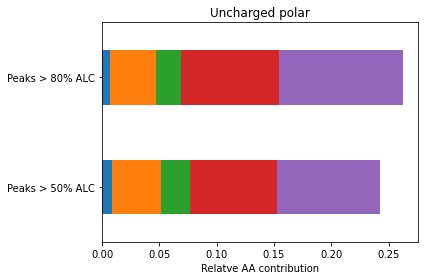

<Figure size 1440x720 with 0 Axes>

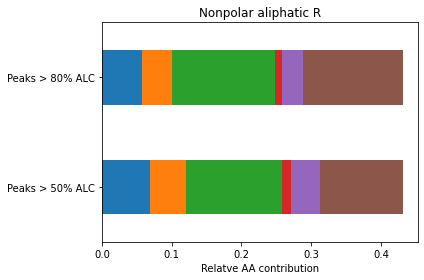

<Figure size 1440x720 with 0 Axes>

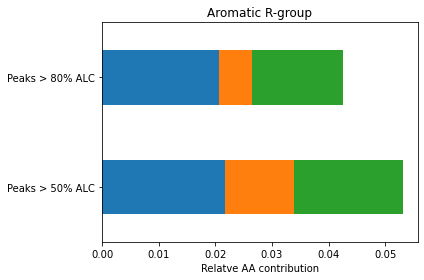

<Figure size 1440x720 with 0 Axes>

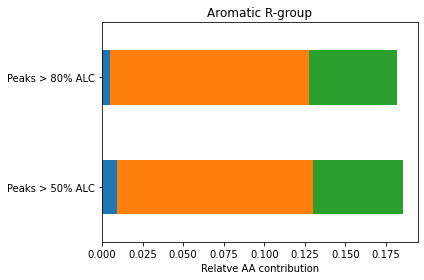

<Figure size 1440x720 with 0 Axes>

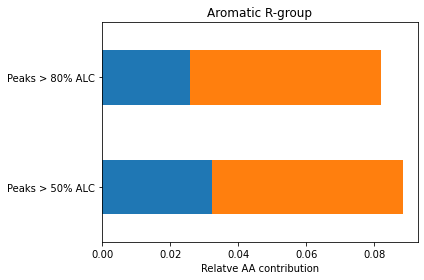

<Figure size 1440x720 with 0 Axes>

In [186]:

AAs = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'K', 'I/L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']


# uncharged polar
ax1 = AA_RelNAAF.plot.barh(y=['C_RelNAAF', \
                             'N_RelNAAF', 'Q_RelNAAF', 'S_RelNAAF', \
                             'T_RelNAAF' \
                            ], x='data source', stacked=True)
ax1.get_legend().remove()
ax1.set_xlabel('Relatve AA contribution')
ax1.set_ylabel('')
ax1.set_title('Uncharged polar')


#ax1.set_xticklabels(AAs, rotation=65)
plt.tight_layout()
plt.figure(figsize=(20,10)) 

# nonpolar, aliphatic R-group
ax2 = AA_RelNAAF.plot.barh(y=['A_RelNAAF', \
                             'G_RelNAAF','I/L_RelNAAF', 'M_RelNAAF', \
                             'P_RelNAAF', \
                             'V_RelNAAF',\
                            ], x='data source', stacked=True)
ax2.get_legend().remove()
ax2.set_xlabel('Relatve AA contribution')
ax2.set_ylabel('')
ax2.set_title('Nonpolar aliphatic R')

#ax2.set_xticklabels(AAs, rotation=65)
plt.tight_layout()
plt.figure(figsize=(20,10)) 

# aromatic R-group
ax3 = AA_RelNAAF.plot.barh(y=['F_RelNAAF', \
                              'W_RelNAAF', 'Y_RelNAAF' \
                            ], x='data source', stacked=True)
ax3.get_legend().remove()
ax3.set_xlabel('Relatve AA contribution')
ax3.set_ylabel('')
ax3.set_title('Aromatic R-group')

#ax3.set_xticklabels(AAs, rotation=65)
plt.tight_layout()
plt.figure(figsize=(20,10)) 

# Basic R-group
ax4 = AA_RelNAAF.plot.barh(y=['H_RelNAAF', 'K_RelNAAF', 'R_RelNAAF', 
                            
                            ], x='data source', stacked=True)
ax4.get_legend().remove()
ax4.set_xlabel('Relatve AA contribution')
ax4.set_ylabel('')
ax4.set_title('Aromatic R-group')

#ax4.set_xticklabels(AAs, rotation=65)
plt.tight_layout()
plt.figure(figsize=(20,10)) 

# acidic R-group
ax5 = AA_RelNAAF.plot.barh(y=['D_RelNAAF', 'E_RelNAAF',  \
                            ], x='data source', stacked=True)
ax5.get_legend().remove()
ax5.set_xlabel('Relatve AA contribution')
ax5.set_ylabel('')
ax5.set_title('Aromatic R-group')

#ax5.set_xticklabels(AAs, rotation=65)
plt.tight_layout()
plt.figure(figsize=(20,10)) 

[Text(0, 0, 'Peaks 50 % ALC'),
 Text(0, 0, 'Peaks 80% ALC'),
 Text(0, 0, 'Comet > XCorr 2.5'),
 Text(0, 0, 'Comet > XCorr 3')]

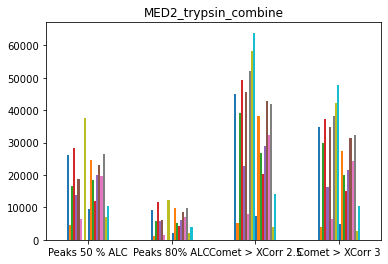

In [8]:
# bar plot of residue totals
# there is no isoleucine (I) in Peaks data, which is why L is really big and I is 0


x_labels = ['Peaks 50 % ALC', 'Peaks 80% ALC', 'Comet > XCorr 2.5', 'Comet > XCorr 3']


ax = AA.plot(kind="bar", title = 'MED2_trypsin_combine')
plt.xticks(rotation=0)
ax.get_legend().remove()
ax.set_xticklabels(x_labels)

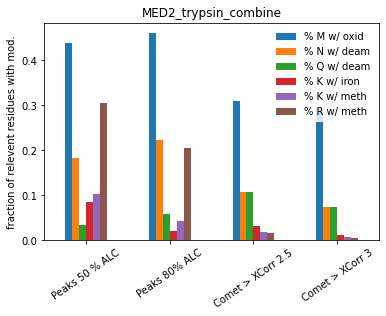

In [9]:
# bar plot of relative modifications

x_labels = ['Peaks 50 % ALC', 'Peaks 80% ALC', 'Comet > XCorr 2.5', 'Comet > XCorr 3']


ax = ptm.plot(kind="bar", title = 'MED2_trypsin_combine')
plt.xticks(rotation=35)
#ax.get_legend().remove()
ax.set_xticklabels(x_labels)
ax.set_ylabel('fraction of relevent residues with mod.')
legend = plt.legend()
legend.get_frame().set_edgecolor('1.0')

In [ ]:
AA.style.background_gradient(cmap ='viridis')

In [ ]:
ptm.style.background_gradient(cmap ='viridis')

In [ ]:
# make the AA dataframe contain relative AA compositions for each dataset

